## Tutorial from Kaggle




In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

# WordCloud and matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

from autocorrect import Speller
import nltk
import seaborn as sns
sns.set(style="darkgrid")
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer # For stemming
nltk.download('punkt')

#from textblob import TextBlob
from langdetect import detect
from nltk.tokenize import word_tokenize
nltk.download('words')

from nltk.stem import WordNetLemmatizer 
english_vocab = set(w.lower() for w in nltk.corpus.words.words())


[nltk_data] Downloading package stopwords to /home/irina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/irina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/irina/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

#remove duplicates from train data
train_df = train_df.drop_duplicates().reset_index(drop=True)

#select related columns
keywords = train_df['keyword']
cols = ['keyword','text', 'target']
train_df = train_df[cols]
print(train_df)

     keyword                                               text  target
0        NaN  Our Deeds are the Reason of this #earthquake M...       1
1        NaN             Forest fire near La Ronge Sask. Canada       1
2        NaN  All residents asked to 'shelter in place' are ...       1
3        NaN  13,000 people receive #wildfires evacuation or...       1
4        NaN  Just got sent this photo from Ruby #Alaska as ...       1
...      ...                                                ...     ...
7608     NaN  Two giant cranes holding a bridge collapse int...       1
7609     NaN  @aria_ahrary @TheTawniest The out of control w...       1
7610     NaN  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611     NaN  Police investigating after an e-bike collided ...       1
7612     NaN  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 3 columns]


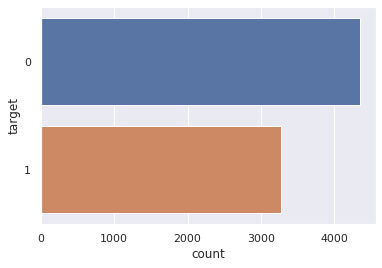

In [3]:
# Class balance
# train.target.value_counts()
sns.countplot(y=train_df.target);

# Preprocessing tweets text

In [4]:
tweet_text = train_df["text"]
sw = stopwords.words("english")
spell = Speller(lang='en')

#from textblob import TextBlob
#from langdetect import detect

ps = PorterStemmer()  
lemmatizer = WordNetLemmatizer()

# Word Stemming
corpus = []
for i in tweet_text:
    processed_text = re.sub(r"http\S+", "", str(i))  #remove links
    processed_text = re.sub('[^a-zA-Z]', ' ', processed_text)
    processed_text = re.sub(r'\n',' ', processed_text)  #remove line breaks
    processed_text = re.sub('\s+', ' ', processed_text).strip() #Remove leading, trailing, and extra spaces
    processed_text = processed_text.lower() # to lower case
    processed_text = processed_text.split() # split words
    
    processed_text = ' '.join(processed_text) 
    newtext = ' '
    tokens = word_tokenize(processed_text)
    for w in tokens:
        w = spell(w)
        if not w in set(sw):
            newtext = newtext+' '+ ps.stem(w)
    corpus.append(newtext)
        
tweet_text = corpus
print(tweet_text)


train_df["text"] = tweet_text

['  deed reason earthquak may allah forgiv us', '  forest fire near la rang ask canada', '  resid ask shelter place notifi offic evacu shelter place order expect', '  peopl receiv wildfir evacu order california', '  got sent photo rubi alaska smoke wildfir pour school', '  rockyfir updat california hwi close direct due lake counti fire caffr wildfir', '  flood disast heavi rain caus flash flood street manit colorado spring area', '  top hill see fire wood', '  emerg evacu happen build across street', '  afraid tornado come area', '  three peopl die heat wave far', '  haha south tampa get flood hah wait second live south tampa gon na gon na fack flood', '  rain flood florida tampala tampa day lost count', '  flood bago myanmar arriv bago', '  damag school bu multi car crash break', '  man', '  love fruit', '  summer love', '  car fast', '  goooooooaaaaaal', '  ridicul', '  london cool', '  love ski', '  wonder day', '  looooool', '  way eat shit', '  ny last week', '  love girlfriend', 

# Dealing with missing keywords

In [5]:
# preprocessing uniqueKeywords
#make set of unique keywords
uniqueKeywords = set()       
keywords = set(keywords)

# uniqueKeywords is without nan values
for word in keywords:
    if not pd.isna(word):
        uniqueKeywords.add(word)

corpus = set()
for k in uniqueKeywords:
    processed_text = re.sub('[^a-zA-Z]', ' ', str(k))
    processed_text = processed_text.lower() # to lower case
    processed_text = processed_text.split() # split words
    processed_text = ' '.join(processed_text)
    
    newtext = ''
    
    tokens = word_tokenize(processed_text)
    for w in tokens:
        #w = spell(w)
        if not w in set(sw):
            if(len(tokens) == 1):
                newtext = ps.stem(w)
            else:
                if (newtext == ''):
                    newtext = ps.stem(w)
                else:
                    newtext = newtext+' '+ ps.stem(w)
    corpus.add(newtext)
      
uniqueKeywords = corpus  
#print(uniqueKeywords)


In [6]:
#retrieving tweets with missing keywords and replacing them with dictionary keywords
for i in range(len(train_df)):
    if pd.isna(train_df.keyword[i]):
        isFound = False
        for word in uniqueKeywords:
            if word in train_df.text[i]:
                train_df.keyword[i] = word
                isFound = True
                break
        #no related keyword was found, inserting artificial keyword
        if not isFound:
            train_df.keyword[i] = "other"
        print(train_df.keyword[i])
        print(train_df.text[i])
       

<ipython-input-6-ed74f8d490fd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.keyword[i] = word
<ipython-input-6-ed74f8d490fd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.keyword[i] = "other"


earthquak
  deed reason earthquak may allah forgiv us
forest fire
  forest fire near la rang ask canada
evacu
  resid ask shelter place notifi offic evacu shelter place order expect
wildfir
  peopl receiv wildfir evacu order california
wildfir
  got sent photo rubi alaska smoke wildfir pour school
wildfir
  rockyfir updat california hwi close direct due lake counti fire caffr wildfir
disast
  flood disast heavi rain caus flash flood street manit colorado spring area
fire
  top hill see fire wood
emerg
  emerg evacu happen build across street
tornado
  afraid tornado come area
heat wave
  three peopl die heat wave far
flood
  haha south tampa get flood hah wait second live south tampa gon na gon na fack flood
flood
  rain flood florida tampala tampa day lost count
flood
  flood bago myanmar arriv bago
crash
  damag school bu multi car crash break
other
  man
other
  love fruit
other
  summer love
other
  car fast
other
  goooooooaaaaaal
other
  ridicul
other
  london cool
other
  love s

In [7]:
print(train_df)
train_df.to_csv("preprocessed_train_data.csv")

            keyword                                               text  target
0         earthquak          deed reason earthquak may allah forgiv us       1
1       forest fire                forest fire near la rang ask canada       1
2             evacu    resid ask shelter place notifi offic evacu s...       1
3           wildfir        peopl receiv wildfir evacu order california       1
4           wildfir    got sent photo rubi alaska smoke wildfir pou...       1
...             ...                                                ...     ...
7608  bridg collaps     two giant crane hold bridg collaps nearbi home       1
7609           fire    aria array thetawniest control wild fire cal...       1
7610        volcano                              utc km volcano hawaii       1
7611         threat    polic investig e bike collid car littl portu...       1
7612        wildfir    latest home raze northern california wildfir...       1

[7613 rows x 3 columns]


# Removing links from tweets

In [24]:
for tweet in tweet_text:
    #print(tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    print(tweet)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

@DavidVonderhaar if you loved me even a little youd put demolition in bo3
Draw Day Demolition Daily football selection service that consistently makes money lay yoÛ_  
demolition 1 &amp; 2 still the most fire freestyles ever
Maxsys is hiring a #Demolition #Workers apply now! #Halifax #jobs 
This sale and demolition trend near Metrotown is sure resulting in some poorly maintained apartments. #burnaby #changefortheworse
Factors to Consider When Hiring a Demolition Company nOxDV
Remaining Sections Of Greystone Psychiatric Hospital Under Demolition 
Pic. 85885473 
witnessed my very first demolition derby today psa that my excitement has not worn down and it's been over 3 hours
Saving the City in Old Town: The Proposed Demolition of 159 West Burton  @MessnerMatthew for @newcity
No civilian population ever deserves demolition may we never forget &amp; learn from our mistakes #Hiroshima
#download &amp; #watch Demolition Frog (2002)  #movie
Demolition Means Progress: Flint Michigan and the Fa

@ToxicSavior_ -a loud bang. He froze on the spot as slowly every head turned towards him. One of the things he hated the most was to be -
daviesmutia: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
@Bang_Me_Up_Guk he was ;-; like he was singing so loud ;-;
Moved on to 'Bang Bang Rock and Roll' by @Art_Brut_ . It's been too long since I've played this one loud. ART BRUT TOP OF THE POPS.
St steel coffee cafetiere exploded this am with loud bang hot coffee &amp; grounds shot over table clean crockery phone
tablet. How?
matako_milk: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
need to work in an office I can bang all my fav Future jams out loud
ColnHarun: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
I don't laugh out loud at many things. But man I really lol 

#Politics DemocracyÛªs hatred for hate: Û_ Dawabsha threaten to erode Israeli democracy. Homegrown terrorism ha...  
Truth...

#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies 
OMEGA MEN Writer Explores Terrorism Religion In an 'Epic KYLE RAYNER Story'  via @Newsarama
Cross-border terrorism: Pakistan caught red-handed again 
CTD arrest three vital criminals from Orangi: KARACHI: Counter-Terrorism Department (CTD) of the Sindh Police ... 
Still domestic terrorism  
DireTube Information ÛÒ Egypt Cyprus and Greece agreed to fightåÊterrorism  
Does this apply to Muslims/terrorism?
Or Catholicism/homophobia?
Perspectives on Terrorism - Understanding Jihadi Proto-States: 
DHS Refuses to Call Chattanooga Û÷Islamic TerrorismÛª out of respect for MUSLIMS ...  via @po_st 
Pakistan's Supreme Court rules to allow military trials for suspects in terrorism cases 
Domestic terrorism. No ifs ands or buts about it. YOU CREATED THIS @GOP 
A good piece on Israeli incitement and Jewis

## TO DO

- assigning keywords to missing keyword labels - DONE
- remove symbols (#, ".. - DONE
- remove links - DONE
- validation
- make slides - IN PROCESS
- TFIDF, LSA, LSTM / RNNs, the list is long
- try different classifiers
- reading discussion board for inspiration


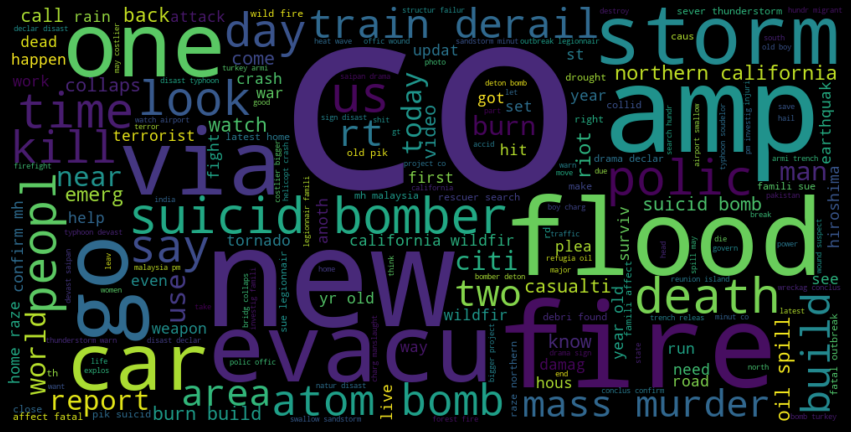

In [55]:
# Data Visualization using WordCloud (for Disaster)

disaster = ' '.join(list(train_df[train_df['target'] == 1] ['text']))
dis_wordcloud = WordCloud(width = 1000, height = 500).generate(disaster) # Generate a word cloud image
plt.figure(figsize = (15,8), facecolor = 'k')
plt.imshow(dis_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


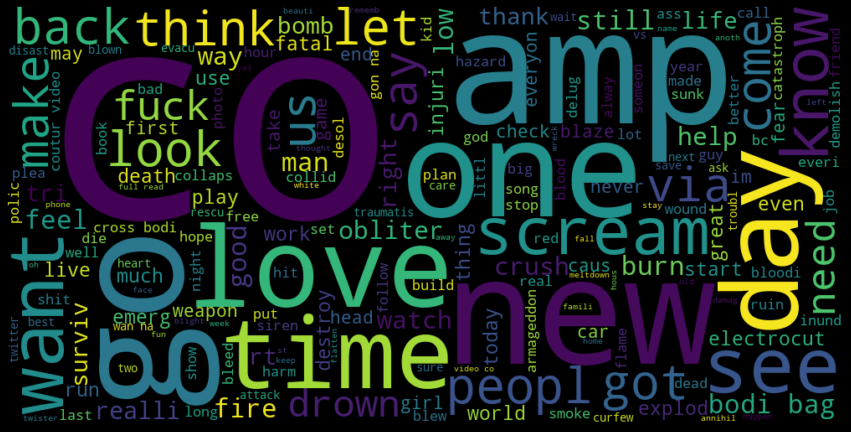

In [56]:
# Data Visualization using WordCloud (for non-Disaster)
non_disaster = ' '.join(list(train_df[train_df['target'] == 0] ['text']))
nondis_wordcloud = WordCloud(width = 1000, height = 500).generate(non_disaster) # Generate a word cloud image
plt.figure(figsize = (15,8), facecolor = 'k')
plt.imshow(nondis_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Let's look at our data... first, an example of what is NOT a disaster tweet.




In [57]:
train_df[train_df["target"] == 0]["text"].values[1]

'  love'

And one that is:

In [58]:
train_df[train_df["target"] == 1]["text"].values[1]

'  forest fire near la rang ask canada'

# TFIDF



In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(tweet_text).toarray()
labels = train_df.target
print(features)
features.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(7613, 3657)

In [64]:
train_vectors = tfidf.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.

test_vectors = tfidf.transform(test_df["text"])



# Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a linear connection. So let's build a linear model and see!


In [65]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()




Let's test our model and see how well it does on the training data. For this we'll use cross-validation - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.


In [66]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.58990536, 0.55719921, 0.60068594])



The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.


In [29]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [31]:
sample_submission = pd.read_csv("sample_submission.csv")

In [32]:
sample_submission["target"] = clf.predict(test_vectors)

In [33]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [20]:
sample_submission.to_csv("submission.csv", index=False)



Now, in the viewer, you can submit the above file to the competition! Good luck!
